# Project: Apartment Price Prediction (Tehran)  
**Course:** Regression (Linear and Nonlinear)  

In this notebook, the following steps are performed: Data Loading → EDA → Preprocessing → Modeling (Linear / Multiple / Polynomial) → Evaluation and Conclusion.


## Importing Required Libraries

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PolynomialFeatures
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.optimize import curve_fit
from sklearn.gaussian_process.kernels import RationalQuadratic, Exponentiation

## Downloading Data

In [2]:
!wget -nv -O HousePrice.csv "https://media1.maktabkhooneh.org/courses/projects/1632300362534233.csv?expire=1759503929&token=639f62c4246709e6e535fd105c0125c2&md5=Y59ixCRnCeblNf0QXAElwg==&_gl=1*8sn7ex*_gcl_au*MTAyMDc3MzE5Ny4xNzU0NTU4NDUxLjI0NDQ4MDc2My4xNzU5MTI2MDE4LjE3NTkxMjYwMTg."

2025-10-09 00:53:53 URL:https://media1.maktabkhooneh.org/courses/projects/1632300362534233.csv?expire=1759503929&token=639f62c4246709e6e535fd105c0125c2&md5=Y59ixCRnCeblNf0QXAElwg==&_gl=1*8sn7ex*_gcl_au*MTAyMDc3MzE5Ny4xNzU0NTU4NDUxLjI0NDQ4MDc2My4xNzU5MTI2MDE4LjE3NTkxMjYwMTg. [190184/190184] -> "HousePrice.csv" [1]


## Reading Data

In [103]:
df = pd.read_csv("HousePrice.csv")

## Data Overview

In [104]:
df.head(10)

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1.850000e+09,61666.67
1,60,1,True,True,True,Shahran,1.850000e+09,61666.67
2,79,2,True,True,True,Pardis,5.500000e+08,18333.33
3,95,2,True,True,True,Shahrake Qods,9.025000e+08,30083.33
4,123,2,True,True,True,Shahrake Gharb,7.000000e+09,233333.33
5,70,2,True,True,False,North Program Organization,2.050000e+09,68333.33
6,87,2,True,True,True,Pardis,6.000000e+08,20000.00
7,59,1,True,True,True,Shahran,2.150000e+09,71666.67
8,54,2,True,True,False,Andisheh,4.930000e+08,16433.33
9,71,1,True,True,True,West Ferdows Boulevard,2.370000e+09,79000.00


In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3479 entries, 0 to 3478
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Area        3479 non-null   object 
 1   Room        3479 non-null   int64  
 2   Parking     3479 non-null   bool   
 3   Warehouse   3479 non-null   bool   
 4   Elevator    3479 non-null   bool   
 5   Address     3456 non-null   object 
 6   Price       3479 non-null   float64
 7   Price(USD)  3479 non-null   float64
dtypes: bool(3), float64(2), int64(1), object(2)
memory usage: 146.2+ KB


In [106]:
df.describe()

,Room,Price,Price(USD)
count,3479.000000,3.479000e+03,3.479000e+03
mean,2.079908,5.359023e+09,1.786341e+05
std,0.758275,8.099935e+09,2.699978e+05
min,0.000000,3.600000e+06,1.200000e+02
25%,2.000000,1.418250e+09,4.727500e+04
50%,2.000000,2.900000e+09,9.666667e+04
75%,2.000000,6.000000e+09,2.000000e+05
max,5.000000,9.240000e+10,3.080000e+06


# Clean the Data

## Exploring the Area Column

In [107]:
df['Area'] = pd.to_numeric(df['Area'], errors='coerce')

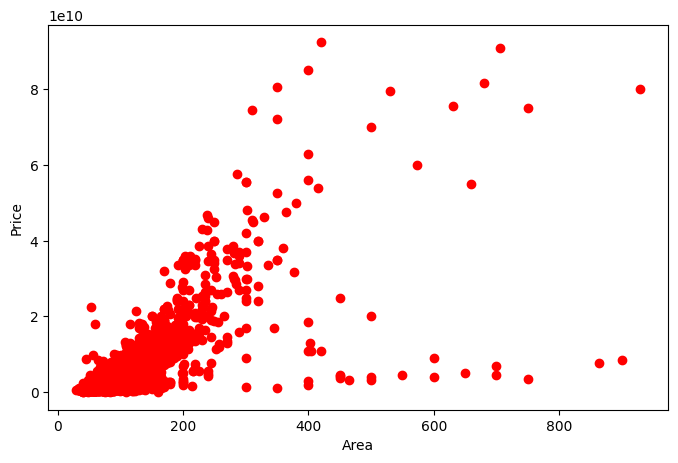

In [108]:
plt.figure(figsize=(8, 5))
x_data, y_data = (df['Area'].values, df['Price'].values)
plt.plot(x_data, y_data, 'ro')
plt.xlabel('Area')
plt.ylabel('Price')
plt.show()

## Initial Cleaning for the Area

In [109]:
df['Area'] = df['Area'].astype(str).str.replace(',', '').str.extract('(\d+)').astype(float)

## Removing Outliers

In [110]:
Q1 = df['Area'].quantile(0.20)
Q2 = df['Area'].quantile(0.80)
IQR = Q2 - Q1
upper_limit = Q2 + 1.5 * IQR
df = df[df['Area'] <= upper_limit]

## Re-plotting the Area

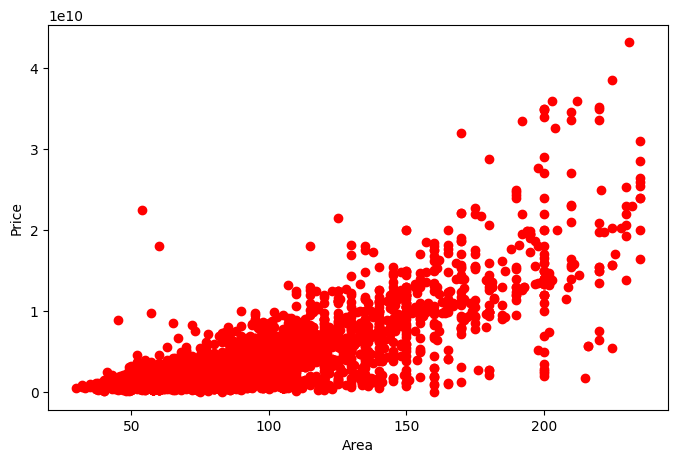

In [111]:
plt.figure(figsize=(8, 5))
x_data, y_data = (df['Area'].values, df['Price'].values)
plt.plot(x_data, y_data, 'ro')
plt.xlabel('Area')
plt.ylabel('Price')
plt.show()

## Converting Boolean Features to Numeric

In [112]:
for col in ['Parking', 'Warehouse', 'Elevator']:
    df[col] = df[col].astype(int)

## Adding a New Feature with Target Encoding for Address

In [113]:
df['RegionMeanPrice'] = df.groupby('Address')['Price'].transform('mean')

## Dropping Rows with NaN Values

In [114]:
df = df.dropna(subset=['Area', 'Room', 'Price', 'RegionMeanPrice'])

## Visual Data Exploration (Histogram)

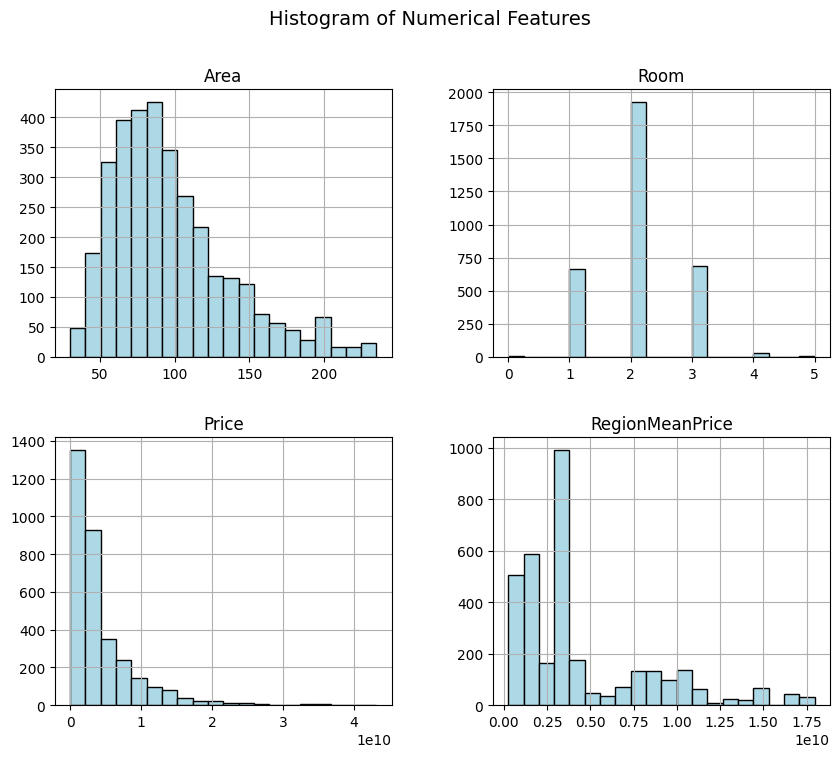

In [115]:
numeric_cols = ['Area', 'Room', 'Price', 'RegionMeanPrice']
df[numeric_cols].hist(figsize=(10, 8), bins=20, color='lightblue', edgecolor='black')
plt.suptitle("Histogram of Numerical Features", fontsize=14)
plt.show()

## Visual Data Exploration (Correlation Map)

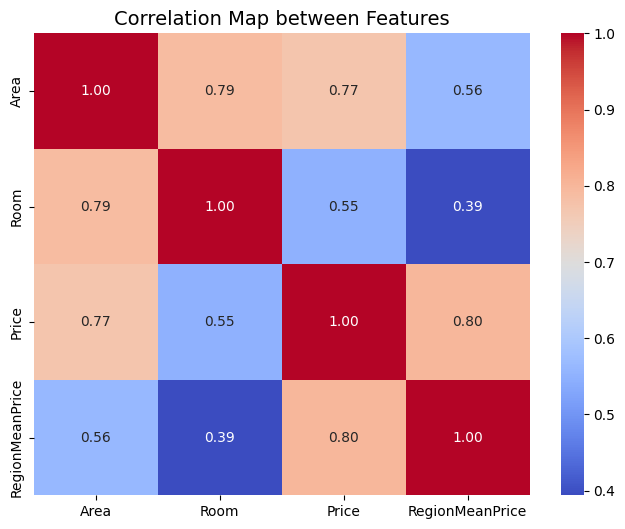

In [116]:
plt.figure(figsize=(8, 6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Map between Features", fontsize=14)
plt.show()

## Preparing Data for Model

In [117]:
X = df[['Area', 'Room', 'Parking', 'Warehouse', 'Elevator', 'RegionMeanPrice']]
y = df['Price']

## Splitting Data

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Select the Proper Algorithm

## Simple Linear Regression

In [119]:
X_area = df[['Area']]
y_area = df['Price']
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_area, y_area, test_size=0.2, random_state=42)

simple_model = LinearRegression()
simple_model.fit(X_train_a, y_train_a)
y_pred_simple = simple_model.predict(X_test_a)

r2_simple = r2_score(y_test_a, y_pred_simple)
mae_simple = mean_absolute_error(y_test_a, y_pred_simple)
rmse_simple = mean_squared_error(y_test_a, y_pred_simple)**0.5

In [120]:
print("R2:", r2_simple)
print("MAE:", mae_simple)
print("RMSE:", rmse_simple)

R2: 0.5563290858931478
MAE: 2181205909.856263
RMSE: 3457741891.630575


Text(0.5, 1.0, 'Simple Linear Regression (Area)')

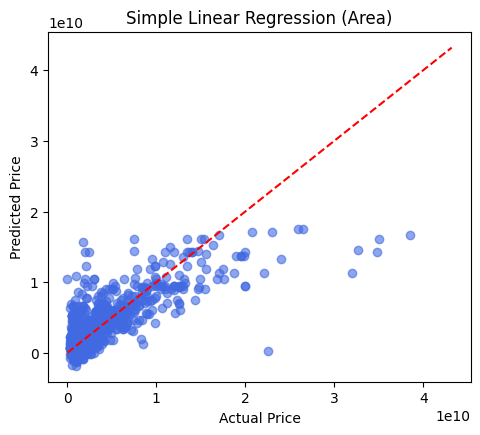

In [121]:
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.scatter(y_test_a, y_pred_simple, color='royalblue', alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Simple Linear Regression (Area)")

## Multiple Linear Regression

In [122]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

r2_linear = r2_score(y_test, y_pred_linear)
mae_linear = mean_absolute_error(y_test, y_pred_linear)
rmse_linear = mean_squared_error(y_test, y_pred_linear) ** 0.5

In [123]:
print("R2:", r2_linear)
print("MAE:", mae_linear)
print("RMSE:", rmse_linear)

R2: 0.7640174607457471
MAE: 1415358122.3504276
RMSE: 2521749987.477195


Text(0.5, 1.0, 'Linear Regression')

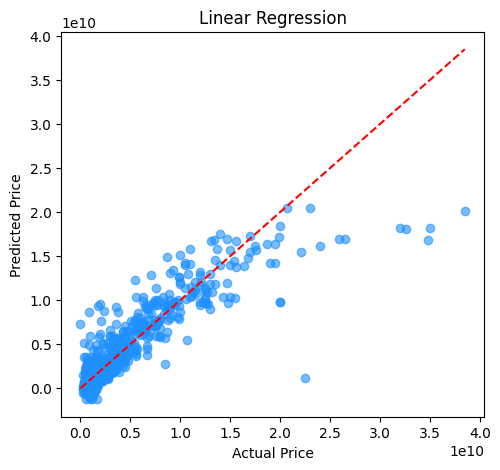

In [124]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_linear, alpha=0.6, color='dodgerblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Linear Regression")

## Nonlinear Regression (Sigmoid)

In [125]:
x_exp = df['Area'].values
y_exp = df['Price'].values

def sigmoid_func(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))

x_train_exp, x_test_exp, y_train_exp, y_test_exp = train_test_split(x_exp, y_exp, test_size=0.2, random_state=42)

initial_L = max(y_train_exp)
initial_k = 0.01
initial_x0 = np.median(x_train_exp)
p0 = [initial_L, initial_k, initial_x0]
popt_sigmoid, _ = curve_fit(sigmoid_func, x_train_exp, y_train_exp, p0=p0, maxfev=20000)

y_pred_sigmoid_test = sigmoid_func(x_test_exp, *popt_sigmoid)
r2_sigmoid = r2_score(y_test_exp, y_pred_sigmoid_test)
mae_sigmoid = mean_absolute_error(y_test_exp, y_pred_sigmoid_test)
rmse_sigmoid = mean_squared_error(y_test_exp, y_pred_sigmoid_test) ** 0.5

In [126]:
print("R2:", r2_sigmoid)
print("MAE:", mae_sigmoid)
print("RMSE:", rmse_sigmoid)

R2: 0.5921801121353341
MAE: 2018430279.40913
RMSE: 3315097399.8505726


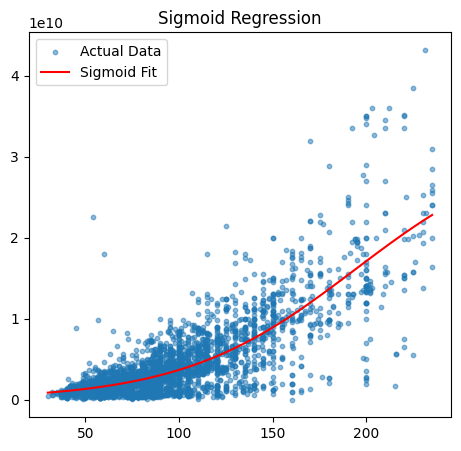

In [127]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(x_exp, y_exp, s=10, alpha=0.5, label="Actual Data")
plt.plot(np.sort(x_exp), sigmoid_func(np.sort(x_exp), *popt_sigmoid), color='red', label="Sigmoid Fit")
plt.title("Sigmoid Regression")
plt.legend()
plt.show()

## Nonlinear Regression (Exponential)

In [128]:
x_exp = df['Area'].values
y_exp = df['Price'].values

def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c

x_train_exp, x_test_exp, y_train_exp, y_test_exp = train_test_split(x_exp, y_exp, test_size=0.2, random_state=42)

p0_exp = [1, 0.0001, 1]
popt_exp, _ = curve_fit(exp_func, x_train_exp, y_train_exp, p0=p0_exp, maxfev=20000)
y_pred_exp_test = exp_func(x_test_exp, *popt_exp)
r2_exp = r2_score(y_test_exp, y_pred_exp_test)
mae_exp = mean_absolute_error(y_test_exp, y_pred_exp_test)
rmse_exp = mean_squared_error(y_test_exp, y_pred_exp_test) ** 0.5

In [129]:
print("R2:", r2_exp)
print("MAE:", mae_exp)
print("RMSE:", rmse_exp)

R2: 0.5913670341348192
MAE: 2021112118.4009998
RMSE: 3318400439.6233926


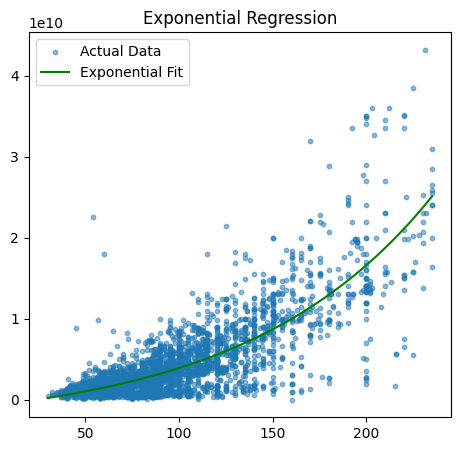

In [130]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.scatter(x_exp, y_exp, s=10, alpha=0.5, label="Actual Data")
plt.plot(np.sort(x_exp), exp_func(np.sort(x_exp), *popt_exp), color='green', label="Exponential Fit")
plt.title("Exponential Regression")
plt.legend()
plt.show()

## Polynomial Regression (Degree 2)

In [131]:
poly = PolynomialFeatures(degree=2)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

poly_model = LinearRegression()
poly_model.fit(X_poly_train, y_train)
y_pred_poly = poly_model.predict(X_poly_test)

r2_poly = r2_score(y_test, y_pred_poly)
mae_poly = mean_absolute_error(y_test, y_pred_poly)
rmse_poly = mean_squared_error(y_test, y_pred_poly) ** 0.5

In [132]:
print("R2:", r2_poly)
print("MAE:", mae_poly)
print("RMSE:", rmse_poly)

R2: 0.8349361628599066
MAE: 1081184800.8213108
RMSE: 2109055753.9848864


Text(0.5, 1.0, 'Polynomial Regression (Degree=2)')

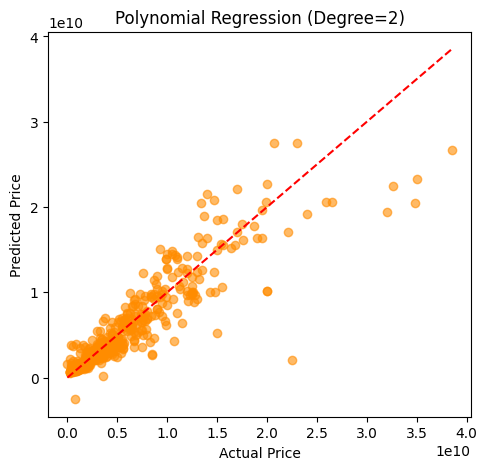

In [133]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_poly, alpha=0.6, color='darkorange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Polynomial Regression (Degree=2)")